# compare between deepsea and positional sinousoid encoding, and between 1 and 2 transformer

# 2 vit deepsea 79.15


=== Run 1/10 ===
Epoch 1/100 | Loss: 4.6485 | Train Acc: 15.24% | Test Acc: 1.62%
Epoch 2/100 | Loss: 3.4654 | Train Acc: 14.32% | Test Acc: 3.24%
Epoch 3/100 | Loss: 2.5984 | Train Acc: 45.08% | Test Acc: 13.36%
Epoch 4/100 | Loss: 1.8676 | Train Acc: 22.00% | Test Acc: 4.45%
Epoch 5/100 | Loss: 1.2987 | Train Acc: 55.84% | Test Acc: 17.00%
Epoch 6/100 | Loss: 0.8775 | Train Acc: 29.88% | Test Acc: 6.48%
Epoch 7/100 | Loss: 0.5589 | Train Acc: 29.60% | Test Acc: 9.72%
Epoch 8/100 | Loss: 0.3584 | Train Acc: 38.52% | Test Acc: 10.12%
Epoch 9/100 | Loss: 0.2085 | Train Acc: 33.28% | Test Acc: 12.15%
Epoch 10/100 | Loss: 0.1269 | Train Acc: 51.56% | Test Acc: 18.62%
Epoch 11/100 | Loss: 0.0772 | Train Acc: 64.00% | Test Acc: 23.08%
Epoch 12/100 | Loss: 0.0451 | Train Acc: 44.48% | Test Acc: 19.43%
Epoch 13/100 | Loss: 0.0258 | Train Acc: 91.12% | Test Acc: 35.63%
Epoch 14/100 | Loss: 0.0161 | Train Acc: 71.80% | Test Acc: 18.22%
Epoch 15/100 | Loss: 0.0088 | Train Acc: 85.60% | Test Acc

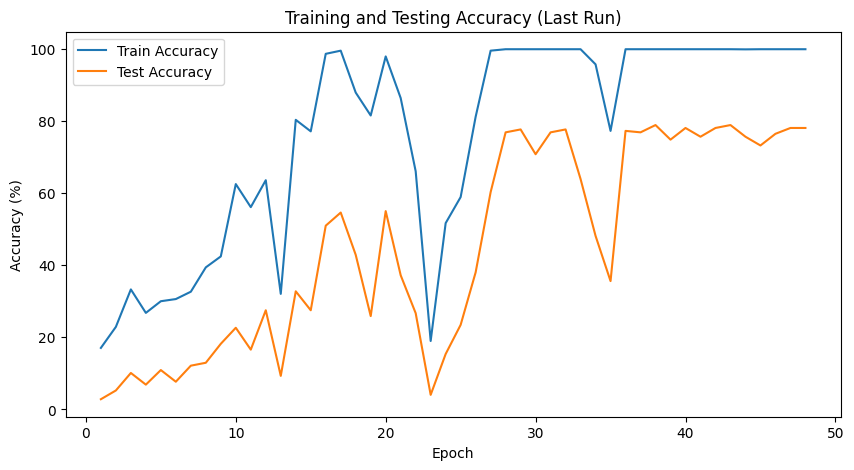

In [11]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering (same as before)
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. ViTDeepSEAEncoder with Normalization (Branch used in each pathway)
###################################
class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style conv block.
      3. A projection of the conv feature maps to d_model.
      4. Addition of positional embeddings.
      5. Transformer encoding (ViT style) over the resulting tokens.
      6. Pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Each branch outputs a 256-D vector
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in k-mer tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # DeepSEA-style conv block. Conv1d expects input shape [B, channels, L]
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # --- Normalization Layer Added Here ---
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        # Project each conv output token (feature map column) to d_model
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        # Define a fixed number of positional embeddings (adjust as needed)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len] for Conv1d
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        # Use positional embeddings (truncate if necessary)
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        # Pool over tokens (mean pooling)
        x = x.mean(dim=1)                # [B, d_model]
        return x

###################################
# 3. Two-Branch Fusion Model with FC Head
###################################
class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,  # Each branch outputs 256-D features; concat gives 512-D
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        # Two independent branches for forward and reverse sequences.
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        # Fully connected layer: 512 -> num_classes
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        # x1: [B, seq_len1] (forward sequence)
        # x2: [B, seq_len2] (reverse sequence)
        f1 = self.vit_branch1(x1)  # [B, d_model] -> [B, 256]
        f2 = self.vit_branch2(x2)  # [B, d_model] -> [B, 256]
        fused = torch.cat([f1, f2], dim=1)  # [B, 512]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 4. Putting It All Together
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples

# We'll build the vocab using both forward and reverse sequences.
tmp_data = []
for (lbl, seq) in raw_data:
    tmp_data.append((lbl, seq))
    tmp_data.append((lbl, reverse_complement(seq)))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

###################################
# 5. Run the Experiment 10 Times with Early Stopping
###################################
num_runs = 10
epochs = 100
patience = 10  # Early stopping patience

all_run_best_acc = []  # To store best test accuracy per run
all_run_best_epoch = []  # To store corresponding epoch per run

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # Create new train-test split and paired data for this run
    train_data, test_data = create_train_test_split(raw_data)
    paired_train = create_paired_data(train_data)
    paired_test  = create_paired_data(test_data)
    
    train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
    test_dataset  = TwoFastaKmerDataset(paired_test,  vocab, k=k)
    
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)
    
    num_classes = train_dataset.get_num_classes()
    vocab_size = train_dataset.get_vocab_size()
    
    # Create the model with the FC head.
    model = TwoViTDeepSEAFusionDNAClassifierWithFC(
        vocab_size=vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        d_model=256,  # Each branch outputs 256-D features => concat gives 512-D
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ).to(device)
    
    # Lower learning rate and weight decay
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    # Create scheduler; note that we'll update it once per epoch with a metric.
    scheduler_student5 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    
    def evaluate_accuracy(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for fwd, rev, labels in data_loader:
                fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
                logits = model(fwd, rev)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return 100.0 * correct / total
    
    train_acc_list = []
    test_acc_list = []
    best_test_acc = 0.0
    best_epoch = 0
    no_improve_epochs = 0  # Counter for early stopping
    
    # Training loop for current run with early stopping
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for fwd, rev, labels in train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(fwd, rev)
            loss = criterion(logits, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc = evaluate_accuracy(model, train_loader)
        test_acc  = evaluate_accuracy(model, test_loader)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
        # Update the scheduler with the monitored metric (e.g., test accuracy)
        scheduler_student5.step(test_acc)
        
        # Early stopping: check for improvement in test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break
    
    all_run_best_acc.append(best_test_acc)
    all_run_best_epoch.append(best_epoch)
    print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")

# Average best accuracy over runs
avg_best_acc = sum(all_run_best_acc) / len(all_run_best_acc)
print(f"\nAverage Highest Test Accuracy over {num_runs} runs: {avg_best_acc:.2f}%")

###################################
# (Optional) Plotting the Training and Testing Accuracy of the Last Run
###################################
epochs_range = range(1, len(train_acc_list) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy (Last Run)")
plt.legend()
plt.show()


# 1 vit deep sea 65.06


=== Run 1/10 ===
Epoch 1/100 | Loss: 5.0407 | Train Acc: 6.40% | Test Acc: 0.81%
Epoch 2/100 | Loss: 4.3360 | Train Acc: 14.64% | Test Acc: 2.02%
Epoch 3/100 | Loss: 3.8790 | Train Acc: 16.08% | Test Acc: 1.62%
Epoch 4/100 | Loss: 3.5322 | Train Acc: 9.76% | Test Acc: 0.40%
Epoch 5/100 | Loss: 3.2238 | Train Acc: 13.92% | Test Acc: 1.62%
Epoch 6/100 | Loss: 2.9854 | Train Acc: 15.76% | Test Acc: 3.24%
Epoch 7/100 | Loss: 2.7496 | Train Acc: 14.80% | Test Acc: 2.43%
Epoch 8/100 | Loss: 2.5233 | Train Acc: 31.08% | Test Acc: 9.72%
Epoch 9/100 | Loss: 2.3057 | Train Acc: 11.88% | Test Acc: 1.21%
Epoch 10/100 | Loss: 2.1200 | Train Acc: 33.64% | Test Acc: 10.12%
Epoch 11/100 | Loss: 1.9325 | Train Acc: 23.64% | Test Acc: 6.07%
Epoch 12/100 | Loss: 1.7646 | Train Acc: 18.04% | Test Acc: 8.10%
Epoch 13/100 | Loss: 1.6449 | Train Acc: 39.00% | Test Acc: 15.38%
Epoch 14/100 | Loss: 1.4386 | Train Acc: 13.60% | Test Acc: 2.43%
Epoch 15/100 | Loss: 1.3076 | Train Acc: 49.44% | Test Acc: 18.62%


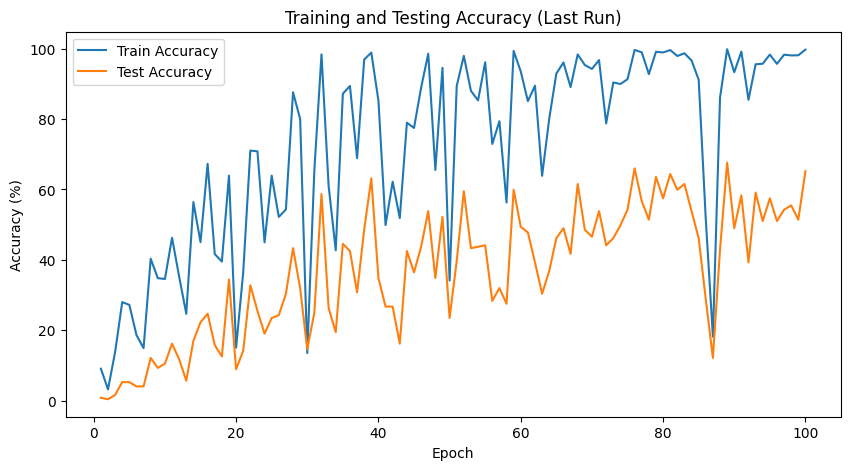

In [8]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering (same as before)
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. ViTDeepSEAEncoder with Normalization (used in the single branch)
###################################
class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style conv block.
      3. A projection of the conv feature maps to d_model.
      4. Addition of positional embeddings.
      5. Transformer encoding (ViT style) over the resulting tokens.
      6. Pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Outputs a 256-D vector
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in k-mer tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # DeepSEA-style conv block. Conv1d expects input shape [B, channels, L]
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # Normalization Layer
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        # Project each conv output token (feature map column) to d_model
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        # Define a fixed number of positional embeddings (adjust as needed)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len] for Conv1d
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        # Use positional embeddings, but if L exceeds max_tokens, interpolate.
        if L > self.max_tokens:
            pos_embed = F.interpolate(self.pos_embedding.transpose(1,2), size=L, mode='linear', align_corners=False).transpose(1,2)
        else:
            pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        # Pool over tokens (mean pooling)
        x = x.mean(dim=1)                # [B, d_model]
        return x

###################################
# 3. Single-Branch Fusion Model with FC Head
###################################
class SingleViTDeepSEAClassifierWithFC(nn.Module):
    """
    Single transformer branch for DNA classification.
    The forward and reverse sequences are concatenated along the token dimension,
    then processed by a single ViTDeepSEAEncoder.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,  # Output dimension of the encoder
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        self.encoder = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        # Fully connected head: maps encoder output to num_classes
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )
    
    def forward(self, x1, x2):
        # x1: [B, seq_len1] (forward sequence)
        # x2: [B, seq_len2] (reverse sequence)
        # Concatenate sequences along token dimension
        x = torch.cat([x1, x2], dim=1)  # [B, seq_len1 + seq_len2]
        encoded = self.encoder(x)       # [B, d_model]
        logits = self.fc(encoded)
        return logits

###################################
# 4. Putting It All Together
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples

# Build vocabulary using both forward and reverse sequences
tmp_data = []
for (lbl, seq) in raw_data:
    tmp_data.append((lbl, seq))
    tmp_data.append((lbl, reverse_complement(seq)))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

###################################
# 5. Run the Experiment 10 Times
###################################
num_runs = 10
epochs = 100

all_run_best_acc = []  # To store best test accuracy per run
all_run_best_epoch = []  # To store corresponding epoch per run

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # Create new train-test split and paired data for this run
    train_data, test_data = create_train_test_split(raw_data)
    paired_train = create_paired_data(train_data)
    paired_test  = create_paired_data(test_data)
    
    train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
    test_dataset  = TwoFastaKmerDataset(paired_test,  vocab, k=k)
    
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)
    
    num_classes = train_dataset.get_num_classes()
    vocab_size = train_dataset.get_vocab_size()
    
    # Create the single-branch model for this run.
    model = SingleViTDeepSEAClassifierWithFC(
        vocab_size=vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        d_model=256,  # Output dimension of encoder
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    def evaluate_accuracy(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for fwd, rev, labels in data_loader:
                fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
                logits = model(fwd, rev)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return 100.0 * correct / total
    
    train_acc_list = []
    test_acc_list = []
    best_test_acc = 0.0
    best_epoch = 0
    
    # Training loop for current run
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for fwd, rev, labels in train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(fwd, rev)
            loss = criterion(logits, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc = evaluate_accuracy(model, train_loader)
        test_acc  = evaluate_accuracy(model, test_loader)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
    
    all_run_best_acc.append(best_test_acc)
    all_run_best_epoch.append(best_epoch)
    print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")

avg_best_acc = sum(all_run_best_acc) / len(all_run_best_acc)
print(f"\nAverage Highest Test Accuracy over {num_runs} runs: {avg_best_acc:.2f}%")

###################################
# (Optional) Plotting the Training and Testing Accuracy of the Last Run
###################################
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy (Last Run)")
plt.legend()
plt.show()


# 2 vit positional encoding 72.83


=== Run 1/10 ===
Epoch 1/100 | Loss: 5.1570 | Train Acc: 9.08% | Test Acc: 0.81%
Epoch 2/100 | Loss: 4.4132 | Train Acc: 20.20% | Test Acc: 3.64%
Epoch 3/100 | Loss: 3.6103 | Train Acc: 37.40% | Test Acc: 11.34%
Epoch 4/100 | Loss: 2.9233 | Train Acc: 47.64% | Test Acc: 17.41%
Epoch 5/100 | Loss: 2.3180 | Train Acc: 59.76% | Test Acc: 25.51%
Epoch 6/100 | Loss: 1.8635 | Train Acc: 72.60% | Test Acc: 35.63%
Epoch 7/100 | Loss: 1.4782 | Train Acc: 80.64% | Test Acc: 41.70%
Epoch 8/100 | Loss: 1.1638 | Train Acc: 86.40% | Test Acc: 50.61%
Epoch 9/100 | Loss: 0.9160 | Train Acc: 89.08% | Test Acc: 53.04%
Epoch 10/100 | Loss: 0.7002 | Train Acc: 92.32% | Test Acc: 55.87%
Epoch 11/100 | Loss: 0.5648 | Train Acc: 93.64% | Test Acc: 57.89%
Epoch 12/100 | Loss: 0.4295 | Train Acc: 94.76% | Test Acc: 62.35%
Epoch 13/100 | Loss: 0.3521 | Train Acc: 96.28% | Test Acc: 61.13%
Epoch 14/100 | Loss: 0.2622 | Train Acc: 96.52% | Test Acc: 61.13%
Epoch 15/100 | Loss: 0.2008 | Train Acc: 97.32% | Test A

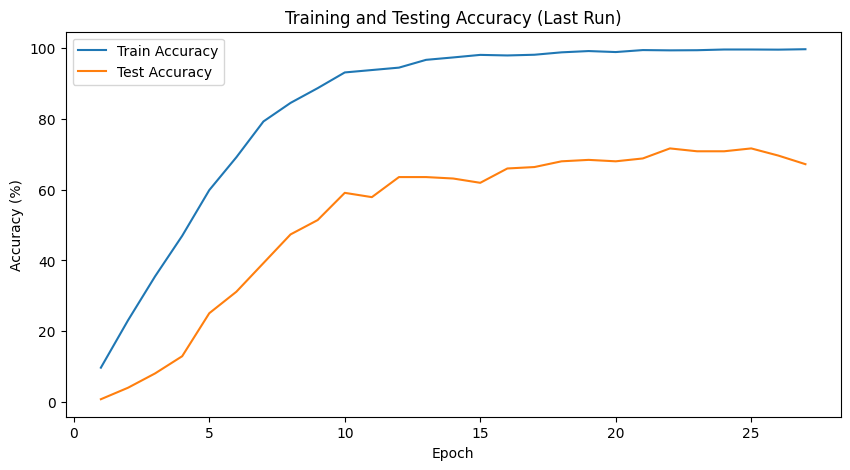

In [9]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering (same as before)
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. ViTPositionalEncoder (replacing DeepSEA)
###################################
class ViTPositionalEncoder(nn.Module):
    """
    A simple transformer encoder that:
      1. Embeds k-mer tokens.
      2. Optionally projects the embedding to d_model.
      3. Adds learnable positional embeddings.
      4. Processes the tokens with a transformer encoder.
      5. Pools over tokens (mean pooling) to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # If embed_dim != d_model, project embeddings
        self.proj = nn.Linear(embed_dim, d_model) if embed_dim != d_model else nn.Identity()
        self.max_seq_len = max_seq_len
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = self.proj(x)                 # [B, seq_len, d_model]
        seq_len = x.size(1)
        # If the sequence length is longer than max_seq_len, interpolate the positional embeddings.
        if seq_len > self.max_seq_len:
            # Interpolate: transpose to [B, d_model, max_seq_len] then interpolate along last dimension.
            pos_embed = F.interpolate(self.pos_embedding.transpose(1, 2), size=seq_len, mode='linear', align_corners=False).transpose(1, 2)
        else:
            pos_embed = self.pos_embedding[:, :seq_len, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, seq_len, d_model]
        x = x.mean(dim=1)                # [B, d_model] (mean pooling)
        return x

###################################
# 3. Two-Branch Fusion Model with FC Head (using two ViTPositionalEncoders)
###################################
class TwoViTPositionalFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,  # Each branch outputs a 256-D vector; concat gives 512-D
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        # Two independent branches for forward and reverse sequences.
        self.branch1 = ViTPositionalEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.branch2 = ViTPositionalEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        # Fully connected head: maps concatenated 2*d_model to num_classes
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        # x1: [B, seq_len1] (forward sequence)
        # x2: [B, seq_len2] (reverse sequence)
        f1 = self.branch1(x1)  # [B, d_model]
        f2 = self.branch2(x2)  # [B, d_model]
        fused = torch.cat([f1, f2], dim=1)  # [B, 2*d_model]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 4. Putting It All Together
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples

# Build vocabulary using both forward and reverse sequences
tmp_data = []
for (lbl, seq) in raw_data:
    tmp_data.append((lbl, seq))
    tmp_data.append((lbl, reverse_complement(seq)))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

###################################
# 5. Run the Experiment 10 Times with Early Stopping
###################################
num_runs = 10
epochs = 100
patience = 5  # Stop training if no improvement for 5 consecutive epochs

all_run_best_acc = []  # To store best test accuracy per run
all_run_best_epoch = []  # To store corresponding epoch per run

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # Create new train-test split and paired data for this run
    train_data, test_data = create_train_test_split(raw_data)
    paired_train = create_paired_data(train_data)
    paired_test  = create_paired_data(test_data)
    
    train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
    test_dataset  = TwoFastaKmerDataset(paired_test, vocab, k=k)
    
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)
    
    num_classes = train_dataset.get_num_classes()
    vocab_size = train_dataset.get_vocab_size()
    
    # Create the two-branch model with positional encoding for each branch.
    model = TwoViTPositionalFusionDNAClassifierWithFC(
        vocab_size=vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        d_model=256,
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    def evaluate_accuracy(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for fwd, rev, labels in data_loader:
                fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
                logits = model(fwd, rev)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return 100.0 * correct / total
    
    train_acc_list = []
    test_acc_list = []
    best_test_acc = 0.0
    best_epoch = 0
    no_improve_epochs = 0  # Counter for early stopping
    
    # Training loop for current run with early stopping
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for fwd, rev, labels in train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(fwd, rev)
            loss = criterion(logits, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc = evaluate_accuracy(model, train_loader)
        test_acc  = evaluate_accuracy(model, test_loader)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
        # Early stopping check: update if improvement, else increment counter.
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
            no_improve_epochs = 0  # reset counter
        else:
            no_improve_epochs += 1
        
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch} after {patience} epochs without improvement.")
            break
    
    all_run_best_acc.append(best_test_acc)
    all_run_best_epoch.append(best_epoch)
    print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")

avg_best_acc = sum(all_run_best_acc) / len(all_run_best_acc)
print(f"\nAverage Highest Test Accuracy over {num_runs} runs: {avg_best_acc:.2f}%")

###################################
# (Optional) Plotting the Training and Testing Accuracy of the Last Run
###################################
epochs_range = range(1, len(train_acc_list) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy (Last Run)")
plt.legend()
plt.show()


# partition eval comaprision

# 2 vit deepsea, 77.65


=== Run 1/10 ===
Epoch 1/100 | Loss: 4.6369 | Train Acc: 11.16% | Test Acc: 1.21%
Epoch 2/100 | Loss: 3.3550 | Train Acc: 10.24% | Test Acc: 1.62%
Epoch 3/100 | Loss: 2.4789 | Train Acc: 28.00% | Test Acc: 5.26%
Epoch 4/100 | Loss: 1.7836 | Train Acc: 15.92% | Test Acc: 3.64%
Epoch 5/100 | Loss: 1.2421 | Train Acc: 15.00% | Test Acc: 2.43%
Epoch 6/100 | Loss: 0.7984 | Train Acc: 19.16% | Test Acc: 4.86%
Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch 7/100 | Loss: 0.4742 | Train Acc: 99.08% | Test Acc: 56.68%
Epoch 8/100 | Loss: 0.3969 | Train Acc: 99.40% | Test Acc: 57.09%
Epoch 9/100 | Loss: 0.3441 | Train Acc: 99.84% | Test Acc: 63.97%
Epoch 10/100 | Loss: 0.3079 | Train Acc: 99.96% | Test Acc: 66.80%
Epoch 11/100 | Loss: 0.2702 | Train Acc: 99.92% | Test Acc: 63.16%
Epoch 12/100 | Loss: 0.2444 | Train Acc: 99.96% | Test Acc: 68.83%
Epoch 13/100 | Loss: 0.2177 | Train Acc: 100.00% | Test Acc: 65.99%
Epoch 14/100 | Loss: 0.1881 | Train Acc: 100.00% | Test Acc: 69

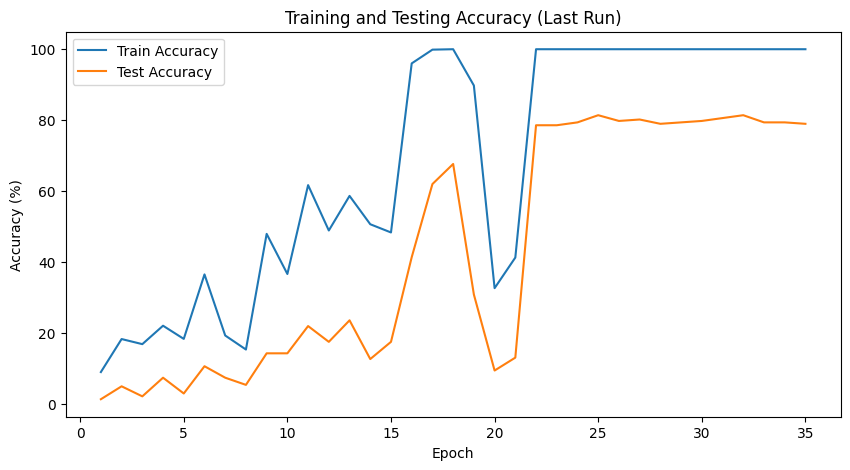

In [14]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering (same as before)
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        # Also create an inverse mapping for evaluation.
        self.idx2label = {i: lbl for lbl, i in self.label2idx.items()}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. ViTDeepSEAEncoder with Normalization (Branch used in each pathway)
###################################
class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style conv block.
      3. A projection of the conv feature maps to d_model.
      4. Addition of positional embeddings.
      5. Transformer encoding (ViT style) over the resulting tokens.
      6. Pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Each branch outputs a 256-D vector
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in k-mer tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # DeepSEA-style conv block. Conv1d expects input shape [B, channels, L]
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # --- Normalization Layer Added Here ---
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        # Project each conv output token (feature map column) to d_model
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        # Define a fixed number of positional embeddings (adjust as needed)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len] for Conv1d
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        # Use positional embeddings (truncate if necessary)
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        # Pool over tokens (mean pooling)
        x = x.mean(dim=1)                # [B, d_model]
        return x

###################################
# 3. Two-Branch Fusion Model with FC Head
###################################
class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,  # Each branch outputs 256-D features; concat gives 512-D
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        # Two independent branches for forward and reverse sequences.
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        # Fully connected layer: 512 -> num_classes
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        # x1: [B, seq_len1] (forward sequence)
        # x2: [B, seq_len2] (reverse sequence)
        f1 = self.vit_branch1(x1)  # [B, d_model] -> [B, 256]
        f2 = self.vit_branch2(x2)  # [B, d_model] -> [B, 256]
        fused = torch.cat([f1, f2], dim=1)  # [B, 512]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 4. Partition Evaluation Function
###################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    # Partition indices based on overall class frequency.
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Evaluation Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

###################################
# 5. Putting It All Together
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples

# Build the vocabulary using both forward and reverse sequences.
tmp_data = []
for (lbl, seq) in raw_data:
    tmp_data.append((lbl, seq))
    tmp_data.append((lbl, reverse_complement(seq)))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

# Global counts for partition evaluation (from filtered raw_data)
global_counts = Counter([label for label, _ in raw_data])

###################################
# 6. Run the Experiment 10 Times with Early Stopping and Partition Evaluation
###################################
num_runs = 10
epochs = 100
patience = 10  # Early stopping patience

all_run_best_acc = []   # To store best test accuracy per run
all_run_best_epoch = [] # To store corresponding epoch per run

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # Create new train-test split and paired data for this run
    train_data, test_data = create_train_test_split(raw_data)
    paired_train = create_paired_data(train_data)
    paired_test  = create_paired_data(test_data)
    
    train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
    test_dataset  = TwoFastaKmerDataset(paired_test,  vocab, k=k)
    
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)
    
    num_classes = train_dataset.get_num_classes()
    vocab_size = train_dataset.get_vocab_size()
    
    # Create the model with the FC head.
    model = TwoViTDeepSEAFusionDNAClassifierWithFC(
        vocab_size=vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        d_model=256,  # Each branch outputs 256-D features => concat gives 512-D
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ).to(device)
    
    # Lower learning rate and weight decay
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    # Scheduler updates based on test accuracy improvements
    scheduler_student5 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
    def evaluate_accuracy(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        true_labels_all = []
        pred_labels_all = []
        with torch.no_grad():
            for fwd, rev, labels in data_loader:
                fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
                logits = model(fwd, rev)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                true_labels_all.extend(labels.cpu().numpy())
                pred_labels_all.extend(preds.cpu().numpy())
        return 100.0 * correct / total, true_labels_all, pred_labels_all
    
    train_acc_list = []
    test_acc_list = []
    best_test_acc = 0.0
    best_epoch = 0
    no_improve_epochs = 0  # Counter for early stopping
    best_state = None  # Save the best model state
    
    # Training loop for current run with early stopping
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for fwd, rev, labels in train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(fwd, rev)
            loss = criterion(logits, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc, _, _ = evaluate_accuracy(model, train_loader)
        test_acc, test_true, test_pred = evaluate_accuracy(model, test_loader)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
        # Update the scheduler with the monitored metric (test accuracy)
        scheduler_student5.step(test_acc)
        
        # Early stopping: check for improvement in test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
            best_state = model.state_dict()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break
    
    # Load the best model state for evaluation
    if best_state is not None:
        model.load_state_dict(best_state)
    
    all_run_best_acc.append(best_test_acc)
    all_run_best_epoch.append(best_epoch)
    print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")
    
    # Partition Evaluation
    # Convert integer labels to actual class labels using test_dataset.idx2label
    _, test_true_int, test_pred_int = evaluate_accuracy(model, test_loader)
    test_true_labels = [test_dataset.idx2label[i] for i in test_true_int]
    test_pred_labels = [test_dataset.idx2label[i] for i in test_pred_int]
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(test_true_labels, test_pred_labels, global_counts)

# Average best accuracy over runs
avg_best_acc = sum(all_run_best_acc) / len(all_run_best_acc)
print(f"\nAverage Highest Test Accuracy over {num_runs} runs: {avg_best_acc:.2f}%")

###################################
# (Optional) Plotting the Training and Testing Accuracy of the Last Run
###################################
epochs_range = range(1, len(train_acc_list) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy (Last Run)")
plt.legend()
plt.show()


# 1 vit deep sea , 66.28


=== Run 1/10 ===
Epoch 1/100 | Loss: 5.0204 | Train Acc: 8.80% | Test Acc: 0.81%
Epoch 2/100 | Loss: 4.3798 | Train Acc: 7.12% | Test Acc: 0.81%
Epoch 3/100 | Loss: 4.0076 | Train Acc: 5.36% | Test Acc: 0.81%
Epoch 4/100 | Loss: 3.7557 | Train Acc: 12.00% | Test Acc: 1.21%
Epoch 5/100 | Loss: 3.5284 | Train Acc: 13.56% | Test Acc: 1.21%
Epoch 6/100 | Loss: 3.2444 | Train Acc: 15.92% | Test Acc: 2.02%
Epoch 7/100 | Loss: 3.0272 | Train Acc: 27.48% | Test Acc: 5.67%
Epoch 8/100 | Loss: 2.7741 | Train Acc: 8.56% | Test Acc: 0.81%
Epoch 9/100 | Loss: 2.5372 | Train Acc: 44.28% | Test Acc: 14.57%
Epoch 10/100 | Loss: 2.3238 | Train Acc: 23.72% | Test Acc: 7.69%
Epoch 11/100 | Loss: 2.1146 | Train Acc: 32.24% | Test Acc: 5.26%
Epoch 12/100 | Loss: 1.9153 | Train Acc: 41.80% | Test Acc: 11.74%
Epoch 13/100 | Loss: 1.7127 | Train Acc: 41.36% | Test Acc: 15.38%
Epoch 14/100 | Loss: 1.5514 | Train Acc: 63.00% | Test Acc: 27.53%
Epoch 15/100 | Loss: 1.3863 | Train Acc: 64.44% | Test Acc: 28.74%


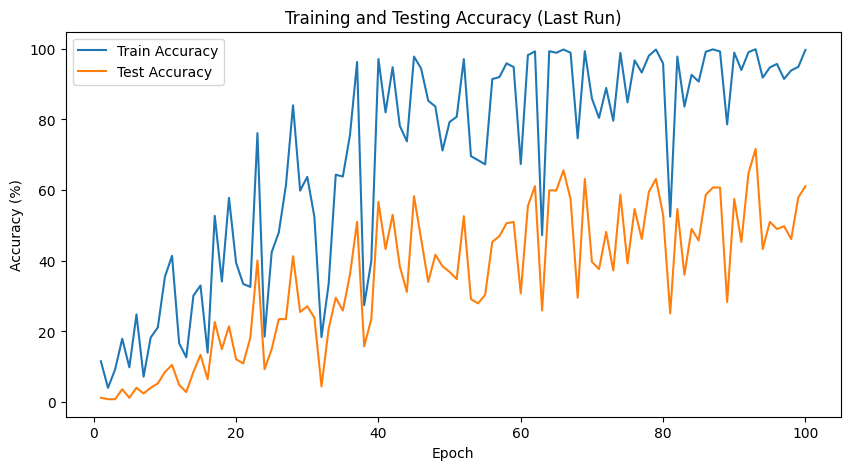

In [2]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering (same as before)
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

###################################
# 2. Dataset with reverse mapping for labels
###################################
class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.idx2label = {i: lbl for lbl, i in self.label2idx.items()}  # Reverse mapping
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 3. ViTDeepSEAEncoder with Normalization (used in the single branch)
###################################
class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style conv block.
      3. A projection of the conv feature maps to d_model.
      4. Addition of positional embeddings.
      5. Transformer encoding (ViT style) over the resulting tokens.
      6. Pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Outputs a 256-D vector
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in k-mer tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # DeepSEA-style conv block. Conv1d expects input shape [B, channels, L]
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # Normalization Layer
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        # Project each conv output token (feature map column) to d_model
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        # Define a fixed number of positional embeddings (adjust as needed)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len] for Conv1d
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        # Use positional embeddings, but if L exceeds max_tokens, interpolate.
        if L > self.max_tokens:
            pos_embed = F.interpolate(self.pos_embedding.transpose(1,2), size=L, mode='linear', align_corners=False).transpose(1,2)
        else:
            pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        # Pool over tokens (mean pooling)
        x = x.mean(dim=1)                # [B, d_model]
        return x

###################################
# 4. Single-Branch Fusion Model with FC Head
###################################
class SingleViTDeepSEAClassifierWithFC(nn.Module):
    """
    Single transformer branch for DNA classification.
    The forward and reverse sequences are concatenated along the token dimension,
    then processed by a single ViTDeepSEAEncoder.
    """
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,  # Output dimension of encoder
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        self.encoder = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        # Fully connected head: maps encoder output to num_classes
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )
    
    def forward(self, x1, x2):
        # x1: [B, seq_len1] (forward sequence)
        # x2: [B, seq_len2] (reverse sequence)
        # Concatenate sequences along token dimension
        x = torch.cat([x1, x2], dim=1)  # [B, seq_len1 + seq_len2]
        encoded = self.encoder(x)       # [B, d_model]
        logits = self.fc(encoded)
        return logits

###################################
# 5. Partition Evaluation Function
###################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    # Partition indices based on overall class frequency.
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

###################################
# 6. Helper: Get Predictions (to later evaluate partitions)
###################################
def get_predictions(model, data_loader, dataset):
    model.eval()
    true_indices = []
    pred_indices = []
    with torch.no_grad():
        for fwd, rev, labels in data_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            logits = model(fwd, rev)
            preds = torch.argmax(logits, dim=1)
            true_indices.extend(labels.cpu().numpy())
            pred_indices.extend(preds.cpu().numpy())
    # Convert index predictions back to original label strings.
    idx2label = dataset.idx2label
    true_labels = [idx2label[idx] for idx in true_indices]
    pred_labels = [idx2label[idx] for idx in pred_indices]
    return true_labels, pred_labels

###################################
# 7. Putting It All Together and Running the Experiment
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples

# Build vocabulary using both forward and reverse sequences.
tmp_data = []
for (lbl, seq) in raw_data:
    tmp_data.append((lbl, seq))
    tmp_data.append((lbl, reverse_complement(seq)))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

# Compute overall label frequencies for partition evaluation.
global_counts = Counter([label for label, seq in raw_data])

###################################
# 8. Run the Experiment 10 Times
###################################
num_runs = 10
epochs = 100

all_run_best_acc = []  # To store best test accuracy per run
all_run_best_epoch = []  # To store corresponding epoch per run

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # Create new train-test split and paired data for this run
    train_data, test_data = create_train_test_split(raw_data)
    paired_train = create_paired_data(train_data)
    paired_test  = create_paired_data(test_data)
    
    train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
    test_dataset  = TwoFastaKmerDataset(paired_test,  vocab, k=k)
    
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)
    
    num_classes = train_dataset.get_num_classes()
    vocab_size = train_dataset.get_vocab_size()
    
    # Create the single-branch model for this run.
    model = SingleViTDeepSEAClassifierWithFC(
        vocab_size=vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        d_model=256,  # Output dimension of encoder
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    def evaluate_accuracy(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for fwd, rev, labels in data_loader:
                fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
                logits = model(fwd, rev)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return 100.0 * correct / total
    
    train_acc_list = []
    test_acc_list = []
    best_test_acc = 0.0
    best_epoch = 0
    
    # Training loop for current run
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for fwd, rev, labels in train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(fwd, rev)
            loss = criterion(logits, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc = evaluate_accuracy(model, train_loader)
        test_acc  = evaluate_accuracy(model, test_loader)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
    
    all_run_best_acc.append(best_test_acc)
    all_run_best_epoch.append(best_epoch)
    print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")
    
    # --- Partition Evaluation on Test Set ---
    true_labels, pred_labels = get_predictions(model, test_loader, test_dataset)
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(true_labels, pred_labels, global_counts)

avg_best_acc = sum(all_run_best_acc) / len(all_run_best_acc)
print(f"\nAverage Highest Test Accuracy over {num_runs} runs: {avg_best_acc:.2f}%")

###################################
# (Optional) Plotting the Training and Testing Accuracy of the Last Run
###################################
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy (Last Run)")
plt.legend()
plt.show()


# 2 vit positional encoding, 74.40


=== Run 1/10 ===
Epoch 1/100 | Loss: 5.1667 | Train Acc: 9.48% | Test Acc: 0.81%
Epoch 2/100 | Loss: 4.4301 | Train Acc: 20.12% | Test Acc: 5.26%
Epoch 3/100 | Loss: 3.6721 | Train Acc: 34.88% | Test Acc: 12.15%
Epoch 4/100 | Loss: 2.9621 | Train Acc: 45.60% | Test Acc: 18.22%
Epoch 5/100 | Loss: 2.3879 | Train Acc: 58.88% | Test Acc: 23.89%
Epoch 6/100 | Loss: 1.9196 | Train Acc: 68.60% | Test Acc: 32.79%
Epoch 7/100 | Loss: 1.5405 | Train Acc: 76.72% | Test Acc: 40.49%
Epoch 8/100 | Loss: 1.2343 | Train Acc: 82.68% | Test Acc: 44.13%
Epoch 9/100 | Loss: 0.9740 | Train Acc: 88.88% | Test Acc: 54.66%
Epoch 10/100 | Loss: 0.7342 | Train Acc: 91.48% | Test Acc: 63.16%
Epoch 11/100 | Loss: 0.5729 | Train Acc: 94.48% | Test Acc: 64.37%
Epoch 12/100 | Loss: 0.4560 | Train Acc: 95.80% | Test Acc: 66.40%
Epoch 13/100 | Loss: 0.3335 | Train Acc: 96.44% | Test Acc: 66.80%
Epoch 14/100 | Loss: 0.2842 | Train Acc: 96.76% | Test Acc: 67.21%
Epoch 15/100 | Loss: 0.1910 | Train Acc: 98.12% | Test A

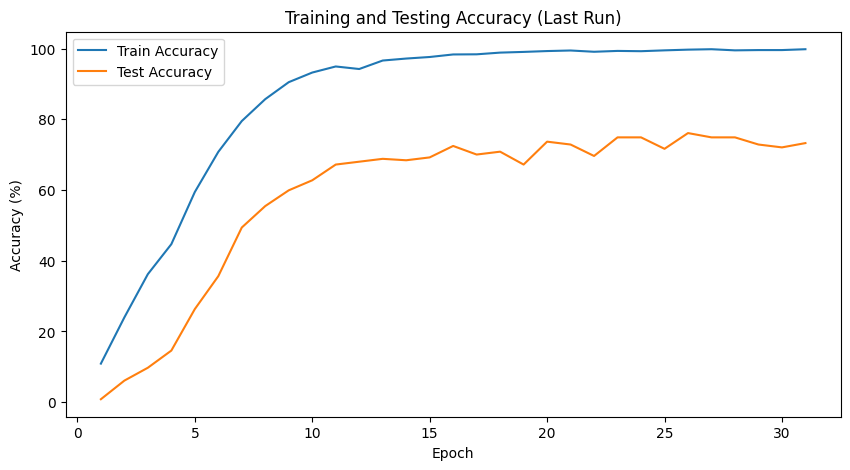

In [3]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering (same as before)
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# Partition Evaluation Function
###################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    # Partition indices based on global counts.
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("Partition Results:")
    if n_cum:
        print(f"  Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("  No samples with global count >= 10.")
    if n_delta8:
        print(f"  Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("  No samples with global count == 8.")
    if n_delta7:
        print(f"  Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("  No samples with global count == 7.")
    if n_delta6:
        print(f"  Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("  No samples with global count == 6.")
    if n_delta5:
        print(f"  Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("  No samples with global count == 5.")

###################################
# 2. ViTPositionalEncoder (replacing DeepSEA)
###################################
class ViTPositionalEncoder(nn.Module):
    """
    A simple transformer encoder that:
      1. Embeds k-mer tokens.
      2. Optionally projects the embedding to d_model.
      3. Adds learnable positional embeddings.
      4. Processes the tokens with a transformer encoder.
      5. Pools over tokens (mean pooling) to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # If embed_dim != d_model, project embeddings
        self.proj = nn.Linear(embed_dim, d_model) if embed_dim != d_model else nn.Identity()
        self.max_seq_len = max_seq_len
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = self.proj(x)                 # [B, seq_len, d_model]
        seq_len = x.size(1)
        # If the sequence length is longer than max_seq_len, interpolate the positional embeddings.
        if seq_len > self.max_seq_len:
            pos_embed = F.interpolate(self.pos_embedding.transpose(1, 2), size=seq_len, mode='linear', align_corners=False).transpose(1, 2)
        else:
            pos_embed = self.pos_embedding[:, :seq_len, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, seq_len, d_model]
        x = x.mean(dim=1)                # [B, d_model] (mean pooling)
        return x

###################################
# 3. Two-Branch Fusion Model with FC Head (using two ViTPositionalEncoders)
###################################
class TwoViTPositionalFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,  # Each branch outputs a 256-D vector; concat gives 512-D
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        # Two independent branches for forward and reverse sequences.
        self.branch1 = ViTPositionalEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.branch2 = ViTPositionalEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        # Fully connected head: maps concatenated 2*d_model to num_classes
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        # x1: [B, seq_len1] (forward sequence)
        # x2: [B, seq_len2] (reverse sequence)
        f1 = self.branch1(x1)  # [B, d_model]
        f2 = self.branch2(x2)  # [B, d_model]
        fused = torch.cat([f1, f2], dim=1)  # [B, 2*d_model]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 4. Putting It All Together
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples

# Build vocabulary using both forward and reverse sequences
tmp_data = []
for (lbl, seq) in raw_data:
    tmp_data.append((lbl, seq))
    tmp_data.append((lbl, reverse_complement(seq)))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

###################################
# 5. Run the Experiment 10 Times with Early Stopping and Partition Evaluation
###################################
num_runs = 10
epochs = 100
patience = 5  # Stop training if no improvement for 5 consecutive epochs

all_run_best_acc = []  # To store best test accuracy per run
all_run_best_epoch = []  # To store corresponding epoch per run

# Precompute global counts (for partition evaluation) from the full filtered raw_data.
global_counts = Counter([label for label, seq in raw_data])

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # Create new train-test split and paired data for this run
    train_data, test_data = create_train_test_split(raw_data)
    paired_train = create_paired_data(train_data)
    paired_test  = create_paired_data(test_data)
    
    train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
    test_dataset  = TwoFastaKmerDataset(paired_test, vocab, k=k)
    
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)
    
    num_classes = train_dataset.get_num_classes()
    vocab_size = train_dataset.get_vocab_size()
    
    # Create the two-branch model with positional encoding for each branch.
    model = TwoViTPositionalFusionDNAClassifierWithFC(
        vocab_size=vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        d_model=256,
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    def evaluate_accuracy(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for fwd, rev, labels in data_loader:
                fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
                logits = model(fwd, rev)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        return 100.0 * correct / total
    
    train_acc_list = []
    test_acc_list = []
    best_test_acc = 0.0
    best_epoch = 0
    no_improve_epochs = 0  # Counter for early stopping
    
    # Training loop for current run with early stopping
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for fwd, rev, labels in train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(fwd, rev)
            loss = criterion(logits, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc = evaluate_accuracy(model, train_loader)
        test_acc  = evaluate_accuracy(model, test_loader)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
        # Early stopping check: update if improvement, else increment counter.
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
            no_improve_epochs = 0  # reset counter
        else:
            no_improve_epochs += 1
        
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch} after {patience} epochs without improvement.")
            break
    
    all_run_best_acc.append(best_test_acc)
    all_run_best_epoch.append(best_epoch)
    print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")
    
    # --- Partition Evaluation ---
    # Get predictions on the test set
    model.eval()
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for fwd, rev, labels in test_loader:
            fwd, rev = fwd.to(device), rev.to(device)
            logits = model(fwd, rev)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_trues.extend(labels.cpu().numpy())
    # Map label indices back to original label names
    idx2label = {v: k for k, v in train_dataset.label2idx.items()}
    true_labels = [idx2label[idx] for idx in all_trues]
    pred_labels = [idx2label[idx] for idx in all_preds]
    # Evaluate partitions based on global counts
    evaluate_partitions(true_labels, pred_labels, global_counts)

avg_best_acc = sum(all_run_best_acc) / len(all_run_best_acc)
print(f"\nAverage Highest Test Accuracy over {num_runs} runs: {avg_best_acc:.2f}%")

###################################
# (Optional) Plotting the Training and Testing Accuracy of the Last Run
###################################
epochs_range = range(1, len(train_acc_list) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy (Last Run)")
plt.legend()
plt.show()


# 2 different param vit, 79.76


=== Run 1/10 ===
Epoch 1/100 | Loss: 4.6424 | Train Acc: 9.12% | Test Acc: 2.02%
Epoch 2/100 | Loss: 3.3845 | Train Acc: 26.08% | Test Acc: 4.45%
Epoch 3/100 | Loss: 2.4041 | Train Acc: 42.00% | Test Acc: 9.31%
Epoch 4/100 | Loss: 1.6503 | Train Acc: 8.04% | Test Acc: 1.21%
Epoch 5/100 | Loss: 1.0899 | Train Acc: 30.56% | Test Acc: 7.69%
Epoch 6/100 | Loss: 0.7099 | Train Acc: 53.24% | Test Acc: 8.50%
Epoch 7/100 | Loss: 0.4161 | Train Acc: 73.48% | Test Acc: 19.03%
Epoch 8/100 | Loss: 0.2451 | Train Acc: 34.04% | Test Acc: 8.91%
Epoch 9/100 | Loss: 0.1335 | Train Acc: 41.16% | Test Acc: 13.36%
Epoch 10/100 | Loss: 0.0725 | Train Acc: 76.28% | Test Acc: 23.89%
Epoch 11/100 | Loss: 0.0340 | Train Acc: 71.60% | Test Acc: 27.13%
Epoch 12/100 | Loss: 0.0193 | Train Acc: 79.68% | Test Acc: 31.17%
Epoch 13/100 | Loss: 0.0102 | Train Acc: 88.80% | Test Acc: 29.55%
Epoch 14/100 | Loss: 0.0056 | Train Acc: 99.76% | Test Acc: 54.25%
Epoch 15/100 | Loss: 0.0030 | Train Acc: 100.00% | Test Acc: 6

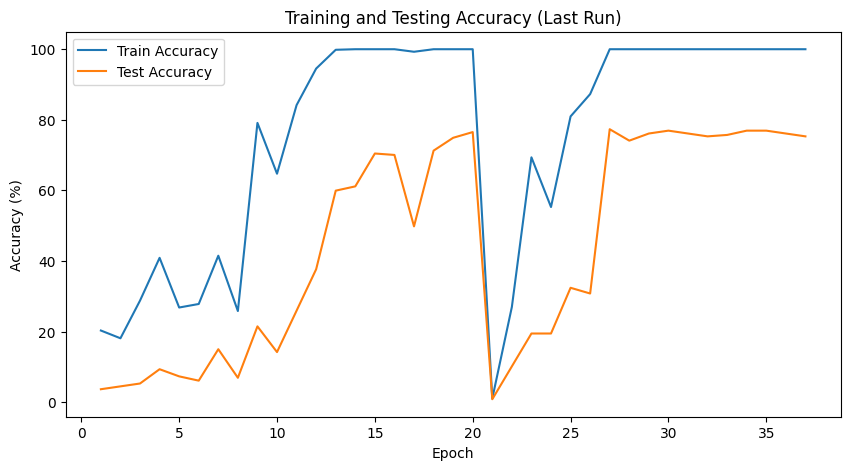

In [17]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        # Also create an inverse mapping for evaluation.
        self.idx2label = {i: lbl for lbl, i in self.label2idx.items()}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. ViTDeepSEAEncoder with Normalization (Branch used in each pathway)
###################################
class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style conv block.
      3. A projection of the conv feature maps to d_model.
      4. Addition of positional embeddings.
      5. Transformer encoding (ViT style) over the resulting tokens.
      6. Pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Each branch outputs a 256-D vector
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in k-mer tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # DeepSEA-style conv block. Conv1d expects input shape [B, channels, L]
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # --- Normalization Layer Added Here ---
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        # Project each conv output token (feature map column) to d_model
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        # Define a fixed number of positional embeddings (adjust as needed)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len] for Conv1d
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        # Use positional embeddings (truncate if necessary)
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        # Pool over tokens (mean pooling)
        x = x.mean(dim=1)                # [B, d_model]
        return x

###################################
# 3. Two-Branch Fusion Model with FC Head
# Modified to accept two parameter dictionaries.
###################################
class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        branch1_params,  # dictionary of parameters for branch 1
        branch2_params,  # dictionary of parameters for branch 2
        fc_in_features=512  # typically 2 * d_model, but adjustable if needed
    ):
        super().__init__()
        # Instantiate each branch using its respective parameter dictionary.
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=branch1_params.get("embed_dim", 128),
            d_model=branch1_params.get("d_model", 256),
            num_conv_filters=branch1_params.get("num_conv_filters", (320, 480, 960)),
            conv_kernel_sizes=branch1_params.get("conv_kernel_sizes", (8, 8, 8)),
            pool_kernel_sizes=branch1_params.get("pool_kernel_sizes", (4, 4)),
            num_transformer_layers=branch1_params.get("num_transformer_layers", 2),
            nhead=branch1_params.get("nhead", 8),
            dropout=branch1_params.get("dropout", 0.1),
            max_seq_len=branch1_params.get("max_seq_len", 1000)
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=branch2_params.get("embed_dim", 128),
            d_model=branch2_params.get("d_model", 256),
            num_conv_filters=branch2_params.get("num_conv_filters", (320, 480, 960)),
            conv_kernel_sizes=branch2_params.get("conv_kernel_sizes", (8, 8, 8)),
            pool_kernel_sizes=branch2_params.get("pool_kernel_sizes", (4, 4)),
            num_transformer_layers=branch2_params.get("num_transformer_layers", 2),
            nhead=branch2_params.get("nhead", 8),
            dropout=branch2_params.get("dropout", 0.1),
            max_seq_len=branch2_params.get("max_seq_len", 1000)
        )
        # Fully connected layer fusing the two branch outputs.
        self.fc = nn.Linear(fc_in_features, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model] -> [B, 256] (by default)
        f2 = self.vit_branch2(x2)  # [B, d_model] -> [B, 256]
        fused = torch.cat([f1, f2], dim=1)  # [B, 512]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 4. Partition Evaluation Function
###################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    # Partition indices based on overall class frequency.
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Evaluation Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

###################################
# 5. Putting It All Together
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples

# Build the vocabulary using both forward and reverse sequences.
tmp_data = []
for (lbl, seq) in raw_data:
    tmp_data.append((lbl, seq))
    tmp_data.append((lbl, reverse_complement(seq)))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

# Global counts for partition evaluation (from filtered raw_data)
global_counts = Counter([label for label, _ in raw_data])

###################################
# 6. Run the Experiment 10 Times with Early Stopping and Partition Evaluation
###################################
num_runs = 10
epochs = 100
patience = 10  # Early stopping patience

all_run_best_acc = []   # To store best test accuracy per run
all_run_best_epoch = [] # To store corresponding epoch per run

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # Create new train-test split and paired data for this run
    train_data, test_data = create_train_test_split(raw_data)
    paired_train = create_paired_data(train_data)
    paired_test  = create_paired_data(test_data)
    
    train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
    test_dataset  = TwoFastaKmerDataset(paired_test,  vocab, k=k)
    
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)
    
    num_classes = train_dataset.get_num_classes()
    vocab_size = train_dataset.get_vocab_size()
    
    # Define separate parameter dictionaries for each branch.
    branch1_params = {
        "embed_dim": 128,
        "d_model": 256,
        "num_conv_filters": (320, 480, 960),
        "conv_kernel_sizes": (8, 8, 8),
        "pool_kernel_sizes": (4, 4),
        "num_transformer_layers": 2,
        "nhead": 8,
        "dropout": 0.1,
        "max_seq_len": 1000
    }
    branch2_params = {
        "embed_dim": 128,
        "d_model": 256,
        # You can change parameters for branch 2 if desired.
        "num_conv_filters": (320, 480, 960),
        "conv_kernel_sizes": (8, 8, 8),
        "pool_kernel_sizes": (4, 4),
        "num_transformer_layers": 1,
        "nhead": 8,
        "dropout": 0.1,
        "max_seq_len": 1000
    }
    
    # Create the model with the FC head.
    model = TwoViTDeepSEAFusionDNAClassifierWithFC(
        vocab_size=vocab_size,
        num_classes=num_classes,
        branch1_params=branch1_params,
        branch2_params=branch2_params,
        fc_in_features=512
    ).to(device)
    
    # Lower learning rate and weight decay
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    # Scheduler updates based on test accuracy improvements
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    
    def evaluate_accuracy(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        true_labels_all = []
        pred_labels_all = []
        with torch.no_grad():
            for fwd, rev, labels in data_loader:
                fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
                logits = model(fwd, rev)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                true_labels_all.extend(labels.cpu().numpy())
                pred_labels_all.extend(preds.cpu().numpy())
        return 100.0 * correct / total, true_labels_all, pred_labels_all
    
    train_acc_list = []
    test_acc_list = []
    best_test_acc = 0.0
    best_epoch = 0
    no_improve_epochs = 0  # Counter for early stopping
    best_state = None  # Save the best model state
    
    # Training loop for current run with early stopping
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for fwd, rev, labels in train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(fwd, rev)
            loss = criterion(logits, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc, _, _ = evaluate_accuracy(model, train_loader)
        test_acc, test_true, test_pred = evaluate_accuracy(model, test_loader)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
        # Update the scheduler with the monitored metric (test accuracy)
        scheduler.step(test_acc)
        
        # Early stopping: check for improvement in test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
            best_state = model.state_dict()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break
    
    # Load the best model state for evaluation
    if best_state is not None:
        model.load_state_dict(best_state)
    
    all_run_best_acc.append(best_test_acc)
    all_run_best_epoch.append(best_epoch)
    print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")
    
    # Partition Evaluation
    # Convert integer labels to actual class labels using test_dataset.idx2label
    _, test_true_int, test_pred_int = evaluate_accuracy(model, test_loader)
    test_true_labels = [test_dataset.idx2label[i] for i in test_true_int]
    test_pred_labels = [test_dataset.idx2label[i] for i in test_pred_int]
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(test_true_labels, test_pred_labels, global_counts)

# Average best accuracy over runs
avg_best_acc = sum(all_run_best_acc) / len(all_run_best_acc)
print(f"\nAverage Highest Test Accuracy over {num_runs} runs: {avg_best_acc:.2f}%")

###################################
# (Optional) Plotting the Training and Testing Accuracy of the Last Run
###################################
epochs_range = range(1, len(train_acc_list) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy (Last Run)")
plt.legend()
plt.show()


# same param, 79.76


=== Run 1/10 ===
Epoch 1/100 | Loss: 4.6592 | Train Acc: 12.20% | Test Acc: 2.02%
Epoch 2/100 | Loss: 3.4254 | Train Acc: 21.16% | Test Acc: 3.64%
Epoch 3/100 | Loss: 2.4667 | Train Acc: 23.96% | Test Acc: 5.67%
Epoch 4/100 | Loss: 1.7862 | Train Acc: 30.00% | Test Acc: 8.10%
Epoch 5/100 | Loss: 1.3024 | Train Acc: 31.28% | Test Acc: 8.91%
Epoch 6/100 | Loss: 0.8975 | Train Acc: 28.20% | Test Acc: 9.31%
Epoch 7/100 | Loss: 0.6159 | Train Acc: 30.76% | Test Acc: 10.53%
Epoch 8/100 | Loss: 0.3894 | Train Acc: 41.44% | Test Acc: 14.57%
Epoch 9/100 | Loss: 0.2303 | Train Acc: 51.20% | Test Acc: 19.43%
Epoch 10/100 | Loss: 0.1517 | Train Acc: 64.48% | Test Acc: 25.51%
Epoch 11/100 | Loss: 0.0868 | Train Acc: 39.96% | Test Acc: 15.79%
Epoch 12/100 | Loss: 0.0514 | Train Acc: 56.64% | Test Acc: 18.62%
Epoch 13/100 | Loss: 0.0287 | Train Acc: 81.76% | Test Acc: 43.32%
Epoch 14/100 | Loss: 0.0170 | Train Acc: 59.24% | Test Acc: 18.22%
Epoch 15/100 | Loss: 0.0111 | Train Acc: 99.68% | Test Acc:

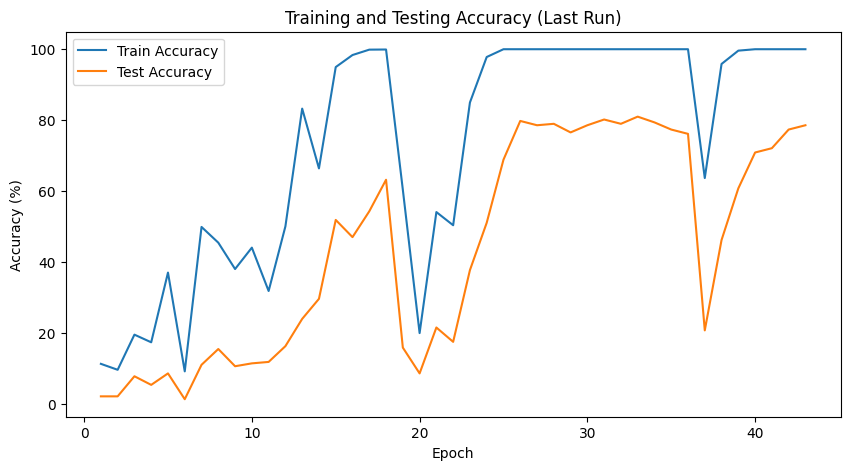

In [18]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        # Also create an inverse mapping for evaluation.
        self.idx2label = {i: lbl for lbl, i in self.label2idx.items()}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. ViTDeepSEAEncoder with Normalization (Branch used in each pathway)
###################################
class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style conv block.
      3. A projection of the conv feature maps to d_model.
      4. Addition of positional embeddings.
      5. Transformer encoding (ViT style) over the resulting tokens.
      6. Pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Each branch outputs a 256-D vector
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in k-mer tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # DeepSEA-style conv block. Conv1d expects input shape [B, channels, L]
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # --- Normalization Layer Added Here ---
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        # Project each conv output token (feature map column) to d_model
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        # Define a fixed number of positional embeddings (adjust as needed)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len] for Conv1d
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        # Use positional embeddings (truncate if necessary)
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        # Pool over tokens (mean pooling)
        x = x.mean(dim=1)                # [B, d_model]
        return x

###################################
# 3. Two-Branch Fusion Model with FC Head
# Modified to accept two parameter dictionaries.
###################################
class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        branch1_params,  # dictionary of parameters for branch 1
        branch2_params,  # dictionary of parameters for branch 2
        fc_in_features=512  # typically 2 * d_model, but adjustable if needed
    ):
        super().__init__()
        # Instantiate each branch using its respective parameter dictionary.
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=branch1_params.get("embed_dim", 128),
            d_model=branch1_params.get("d_model", 256),
            num_conv_filters=branch1_params.get("num_conv_filters", (320, 480, 960)),
            conv_kernel_sizes=branch1_params.get("conv_kernel_sizes", (8, 8, 8)),
            pool_kernel_sizes=branch1_params.get("pool_kernel_sizes", (4, 4)),
            num_transformer_layers=branch1_params.get("num_transformer_layers", 2),
            nhead=branch1_params.get("nhead", 8),
            dropout=branch1_params.get("dropout", 0.1),
            max_seq_len=branch1_params.get("max_seq_len", 1000)
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=branch2_params.get("embed_dim", 128),
            d_model=branch2_params.get("d_model", 256),
            num_conv_filters=branch2_params.get("num_conv_filters", (320, 480, 960)),
            conv_kernel_sizes=branch2_params.get("conv_kernel_sizes", (8, 8, 8)),
            pool_kernel_sizes=branch2_params.get("pool_kernel_sizes", (4, 4)),
            num_transformer_layers=branch2_params.get("num_transformer_layers", 2),
            nhead=branch2_params.get("nhead", 8),
            dropout=branch2_params.get("dropout", 0.1),
            max_seq_len=branch2_params.get("max_seq_len", 1000)
        )
        # Fully connected layer fusing the two branch outputs.
        self.fc = nn.Linear(fc_in_features, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model] -> [B, 256] (by default)
        f2 = self.vit_branch2(x2)  # [B, d_model] -> [B, 256]
        fused = torch.cat([f1, f2], dim=1)  # [B, 512]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 4. Partition Evaluation Function
###################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    # Partition indices based on overall class frequency.
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Evaluation Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

###################################
# 5. Putting It All Together
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples

# Build the vocabulary using both forward and reverse sequences.
tmp_data = []
for (lbl, seq) in raw_data:
    tmp_data.append((lbl, seq))
    tmp_data.append((lbl, reverse_complement(seq)))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

# Global counts for partition evaluation (from filtered raw_data)
global_counts = Counter([label for label, _ in raw_data])

###################################
# 6. Run the Experiment 10 Times with Early Stopping and Partition Evaluation
###################################
num_runs = 10
epochs = 100
patience = 10  # Early stopping patience

all_run_best_acc = []   # To store best test accuracy per run
all_run_best_epoch = [] # To store corresponding epoch per run

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # Create new train-test split and paired data for this run
    train_data, test_data = create_train_test_split(raw_data)
    paired_train = create_paired_data(train_data)
    paired_test  = create_paired_data(test_data)
    
    train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
    test_dataset  = TwoFastaKmerDataset(paired_test,  vocab, k=k)
    
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)
    
    num_classes = train_dataset.get_num_classes()
    vocab_size = train_dataset.get_vocab_size()
    
    # Define separate parameter dictionaries for each branch.
    branch1_params = {
        "embed_dim": 128,
        "d_model": 256,
        "num_conv_filters": (320, 480, 960),
        "conv_kernel_sizes": (8, 8, 8),
        "pool_kernel_sizes": (4, 4),
        "num_transformer_layers": 2,
        "nhead": 8,
        "dropout": 0.1,
        "max_seq_len": 1000
    }
    branch2_params = {
        "embed_dim": 128,
        "d_model": 256,
        # You can change parameters for branch 2 if desired.
        "num_conv_filters": (320, 480, 960),
        "conv_kernel_sizes": (8, 8, 8),
        "pool_kernel_sizes": (4, 4),
        "num_transformer_layers": 2,
        "nhead": 8,
        "dropout": 0.1,
        "max_seq_len": 1000
    }
    
    # Create the model with the FC head.
    model = TwoViTDeepSEAFusionDNAClassifierWithFC(
        vocab_size=vocab_size,
        num_classes=num_classes,
        branch1_params=branch1_params,
        branch2_params=branch2_params,
        fc_in_features=512
    ).to(device)
    
    # Lower learning rate and weight decay
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    # Scheduler updates based on test accuracy improvements
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    
    def evaluate_accuracy(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        true_labels_all = []
        pred_labels_all = []
        with torch.no_grad():
            for fwd, rev, labels in data_loader:
                fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
                logits = model(fwd, rev)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                true_labels_all.extend(labels.cpu().numpy())
                pred_labels_all.extend(preds.cpu().numpy())
        return 100.0 * correct / total, true_labels_all, pred_labels_all
    
    train_acc_list = []
    test_acc_list = []
    best_test_acc = 0.0
    best_epoch = 0
    no_improve_epochs = 0  # Counter for early stopping
    best_state = None  # Save the best model state
    
    # Training loop for current run with early stopping
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for fwd, rev, labels in train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(fwd, rev)
            loss = criterion(logits, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc, _, _ = evaluate_accuracy(model, train_loader)
        test_acc, test_true, test_pred = evaluate_accuracy(model, test_loader)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
        # Update the scheduler with the monitored metric (test accuracy)
        scheduler.step(test_acc)
        
        # Early stopping: check for improvement in test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
            best_state = model.state_dict()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break
    
    # Load the best model state for evaluation
    if best_state is not None:
        model.load_state_dict(best_state)
    
    all_run_best_acc.append(best_test_acc)
    all_run_best_epoch.append(best_epoch)
    print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")
    
    # Partition Evaluation
    # Convert integer labels to actual class labels using test_dataset.idx2label
    _, test_true_int, test_pred_int = evaluate_accuracy(model, test_loader)
    test_true_labels = [test_dataset.idx2label[i] for i in test_true_int]
    test_pred_labels = [test_dataset.idx2label[i] for i in test_pred_int]
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(test_true_labels, test_pred_labels, global_counts)

# Average best accuracy over runs
avg_best_acc = sum(all_run_best_acc) / len(all_run_best_acc)
print(f"\nAverage Highest Test Accuracy over {num_runs} runs: {avg_best_acc:.2f}%")

###################################
# (Optional) Plotting the Training and Testing Accuracy of the Last Run
###################################
epochs_range = range(1, len(train_acc_list) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy (Last Run)")
plt.legend()
plt.show()


# try increase attention, 79.31


=== Run 1/10 ===


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/100 | Loss: 4.6467 | Train Acc: 11.56% | Test Acc: 0.81%
Epoch 2/100 | Loss: 3.4608 | Train Acc: 24.84% | Test Acc: 6.07%
Epoch 3/100 | Loss: 2.6179 | Train Acc: 5.48% | Test Acc: 2.02%
Epoch 4/100 | Loss: 1.9126 | Train Acc: 15.36% | Test Acc: 4.05%
Epoch 5/100 | Loss: 1.3447 | Train Acc: 22.84% | Test Acc: 6.07%
Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.
Epoch 6/100 | Loss: 0.8655 | Train Acc: 63.84% | Test Acc: 17.41%
Epoch 7/100 | Loss: 0.6160 | Train Acc: 67.44% | Test Acc: 19.43%
Epoch 8/100 | Loss: 0.4386 | Train Acc: 87.64% | Test Acc: 34.41%
Epoch 9/100 | Loss: 0.3005 | Train Acc: 89.40% | Test Acc: 32.39%
Epoch 10/100 | Loss: 0.2078 | Train Acc: 79.52% | Test Acc: 27.13%
Epoch 11/100 | Loss: 0.1448 | Train Acc: 97.92% | Test Acc: 43.72%
Epoch 12/100 | Loss: 0.0871 | Train Acc: 97.56% | Test Acc: 46.56%
Epoch 13/100 | Loss: 0.0590 | Train Acc: 99.48% | Test Acc: 46.56%
Epoch 14/100 | Loss: 0.0358 | Train Acc: 99.16% | Test Acc: 50.20%
Epoch 15/100 | 

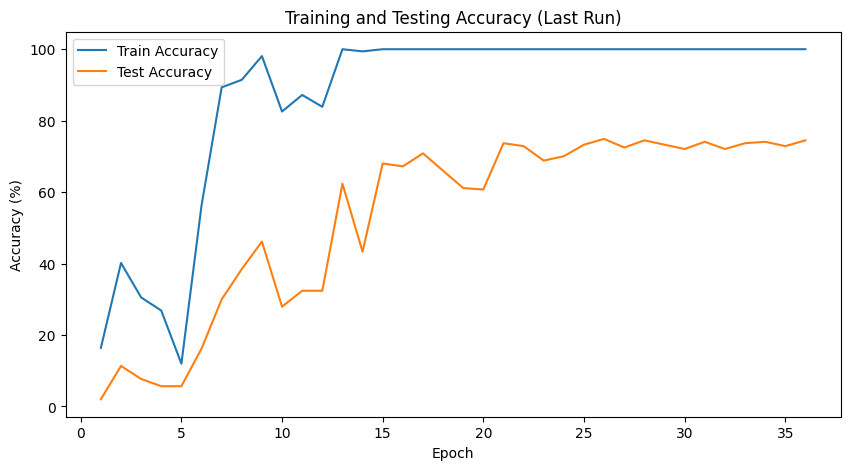

In [1]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        # Also create an inverse mapping for evaluation.
        self.idx2label = {i: lbl for lbl, i in self.label2idx.items()}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. ViTDeepSEAEncoder with Normalization (Branch used in each pathway)
###################################
class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style conv block.
      3. A projection of the conv feature maps to d_model.
      4. Addition of positional embeddings.
      5. Transformer encoding (ViT style) over the resulting tokens.
      6. Pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Each branch outputs a 256-D vector
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in k-mer tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # DeepSEA-style conv block. Conv1d expects input shape [B, channels, L]
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # --- Normalization Layer Added Here ---
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        # Project each conv output token (feature map column) to d_model
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        # Define a fixed number of positional embeddings (adjust as needed)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len] for Conv1d
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        # Use positional embeddings (truncate if necessary)
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        # Pool over tokens (mean pooling)
        x = x.mean(dim=1)                # [B, d_model]
        return x

###################################
# 3. Two-Branch Fusion Model with FC Head
# Modified to accept two parameter dictionaries.
###################################
class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        branch1_params,  # dictionary of parameters for branch 1
        branch2_params,  # dictionary of parameters for branch 2
        fc_in_features=512  # typically 2 * d_model, but adjustable if needed
    ):
        super().__init__()
        # Instantiate each branch using its respective parameter dictionary.
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=branch1_params.get("embed_dim", 128),
            d_model=branch1_params.get("d_model", 256),
            num_conv_filters=branch1_params.get("num_conv_filters", (320, 480, 960)),
            conv_kernel_sizes=branch1_params.get("conv_kernel_sizes", (8, 8, 8)),
            pool_kernel_sizes=branch1_params.get("pool_kernel_sizes", (4, 4)),
            num_transformer_layers=branch1_params.get("num_transformer_layers", 2),
            nhead=branch1_params.get("nhead", 8),
            dropout=branch1_params.get("dropout", 0.1),
            max_seq_len=branch1_params.get("max_seq_len", 1000)
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=branch2_params.get("embed_dim", 128),
            d_model=branch2_params.get("d_model", 256),
            num_conv_filters=branch2_params.get("num_conv_filters", (320, 480, 960)),
            conv_kernel_sizes=branch2_params.get("conv_kernel_sizes", (8, 8, 8)),
            pool_kernel_sizes=branch2_params.get("pool_kernel_sizes", (4, 4)),
            num_transformer_layers=branch2_params.get("num_transformer_layers", 2),
            nhead=branch2_params.get("nhead", 8),
            dropout=branch2_params.get("dropout", 0.1),
            max_seq_len=branch2_params.get("max_seq_len", 1000)
        )
        # Fully connected layer fusing the two branch outputs.
        self.fc = nn.Linear(fc_in_features, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model] -> [B, 256] (by default)
        f2 = self.vit_branch2(x2)  # [B, d_model] -> [B, 256]
        fused = torch.cat([f1, f2], dim=1)  # [B, 512]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 4. Partition Evaluation Function
###################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    # Partition indices based on overall class frequency.
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Evaluation Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

###################################
# 5. Putting It All Together
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples

# Build the vocabulary using both forward and reverse sequences.
tmp_data = []
for (lbl, seq) in raw_data:
    tmp_data.append((lbl, seq))
    tmp_data.append((lbl, reverse_complement(seq)))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

# Global counts for partition evaluation (from filtered raw_data)
global_counts = Counter([label for label, _ in raw_data])

###################################
# 6. Run the Experiment 10 Times with Early Stopping and Partition Evaluation
###################################
num_runs = 10
epochs = 100
patience = 10  # Early stopping patience

all_run_best_acc = []   # To store best test accuracy per run
all_run_best_epoch = [] # To store corresponding epoch per run

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # Create new train-test split and paired data for this run
    train_data, test_data = create_train_test_split(raw_data)
    paired_train = create_paired_data(train_data)
    paired_test  = create_paired_data(test_data)
    
    train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
    test_dataset  = TwoFastaKmerDataset(paired_test,  vocab, k=k)
    
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)
    
    num_classes = train_dataset.get_num_classes()
    vocab_size = train_dataset.get_vocab_size()
    
    # Define separate parameter dictionaries for each branch.
    branch1_params = {
        "embed_dim": 128,
        "d_model": 256,
        "num_conv_filters": (320, 480, 960),
        "conv_kernel_sizes": (8, 8, 8),
        "pool_kernel_sizes": (4, 4),
        "num_transformer_layers": 3,
        "nhead": 8,
        "dropout": 0.1,
        "max_seq_len": 1000
    }
    branch2_params = {
        "embed_dim": 128,
        "d_model": 256,
        # You can change parameters for branch 2 if desired.
        "num_conv_filters": (320, 480, 960),
        "conv_kernel_sizes": (8, 8, 8),
        "pool_kernel_sizes": (4, 4),
        "num_transformer_layers": 2,
        "nhead": 8,
        "dropout": 0.1,
        "max_seq_len": 1000
    }
    
    # Create the model with the FC head.
    model = TwoViTDeepSEAFusionDNAClassifierWithFC(
        vocab_size=vocab_size,
        num_classes=num_classes,
        branch1_params=branch1_params,
        branch2_params=branch2_params,
        fc_in_features=512
    ).to(device)
    
    # Lower learning rate and weight decay
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    # Scheduler updates based on test accuracy improvements
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    
    def evaluate_accuracy(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        true_labels_all = []
        pred_labels_all = []
        with torch.no_grad():
            for fwd, rev, labels in data_loader:
                fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
                logits = model(fwd, rev)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                true_labels_all.extend(labels.cpu().numpy())
                pred_labels_all.extend(preds.cpu().numpy())
        return 100.0 * correct / total, true_labels_all, pred_labels_all
    
    train_acc_list = []
    test_acc_list = []
    best_test_acc = 0.0
    best_epoch = 0
    no_improve_epochs = 0  # Counter for early stopping
    best_state = None  # Save the best model state
    
    # Training loop for current run with early stopping
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for fwd, rev, labels in train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(fwd, rev)
            loss = criterion(logits, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc, _, _ = evaluate_accuracy(model, train_loader)
        test_acc, test_true, test_pred = evaluate_accuracy(model, test_loader)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
        # Update the scheduler with the monitored metric (test accuracy)
        scheduler.step(test_acc)
        
        # Early stopping: check for improvement in test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
            best_state = model.state_dict()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break
    
    # Load the best model state for evaluation
    if best_state is not None:
        model.load_state_dict(best_state)
    
    all_run_best_acc.append(best_test_acc)
    all_run_best_epoch.append(best_epoch)
    print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")
    
    # Partition Evaluation
    # Convert integer labels to actual class labels using test_dataset.idx2label
    _, test_true_int, test_pred_int = evaluate_accuracy(model, test_loader)
    test_true_labels = [test_dataset.idx2label[i] for i in test_true_int]
    test_pred_labels = [test_dataset.idx2label[i] for i in test_pred_int]
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(test_true_labels, test_pred_labels, global_counts)

# Average best accuracy over runs
avg_best_acc = sum(all_run_best_acc) / len(all_run_best_acc)
print(f"\nAverage Highest Test Accuracy over {num_runs} runs: {avg_best_acc:.2f}%")

###################################
# (Optional) Plotting the Training and Testing Accuracy of the Last Run
###################################
epochs_range = range(1, len(train_acc_list) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy (Last Run)")
plt.legend()
plt.show()


# increase input spactial


=== Run 1/10 ===
Epoch 1/100 | Loss: 4.5624 | Train Acc: 11.48% | Test Acc: 2.43%
Epoch 2/100 | Loss: 3.1778 | Train Acc: 35.12% | Test Acc: 8.50%
Epoch 3/100 | Loss: 2.2424 | Train Acc: 12.40% | Test Acc: 2.83%
Epoch 4/100 | Loss: 1.5703 | Train Acc: 63.04% | Test Acc: 19.84%
Epoch 5/100 | Loss: 1.0547 | Train Acc: 47.44% | Test Acc: 15.38%
Epoch 6/100 | Loss: 0.6833 | Train Acc: 65.20% | Test Acc: 21.46%
Epoch 7/100 | Loss: 0.4135 | Train Acc: 53.80% | Test Acc: 14.17%
Epoch 8/100 | Loss: 0.2256 | Train Acc: 32.84% | Test Acc: 7.69%
Epoch 9/100 | Loss: 0.1329 | Train Acc: 55.40% | Test Acc: 16.19%
Epoch 10/100 | Loss: 0.0732 | Train Acc: 49.32% | Test Acc: 18.22%
Epoch 11/100 | Loss: 0.0443 | Train Acc: 87.72% | Test Acc: 25.91%
Epoch 12/100 | Loss: 0.0200 | Train Acc: 85.04% | Test Acc: 30.36%
Epoch 13/100 | Loss: 0.0097 | Train Acc: 66.24% | Test Acc: 25.91%
Epoch 14/100 | Loss: 0.0052 | Train Acc: 90.84% | Test Acc: 33.60%
Epoch 15/100 | Loss: 0.0033 | Train Acc: 99.92% | Test Ac

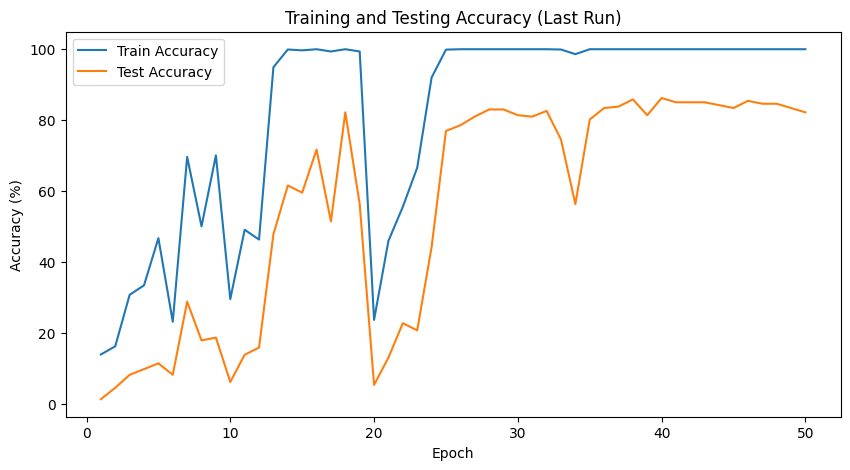

In [2]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        # Also create an inverse mapping for evaluation.
        self.idx2label = {i: lbl for lbl, i in self.label2idx.items()}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. ViTDeepSEAEncoder with Normalization (Branch used in each pathway)
###################################
class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style conv block.
      3. A projection of the conv feature maps to d_model.
      4. Addition of positional embeddings.
      5. Transformer encoding (ViT style) over the resulting tokens.
      6. Pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Each branch outputs a 256-D vector
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in k-mer tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # DeepSEA-style conv block. Conv1d expects input shape [B, channels, L]
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # --- Normalization Layer Added Here ---
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        # Project each conv output token (feature map column) to d_model
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        # Define a fixed number of positional embeddings (adjust as needed)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len] for Conv1d
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        # Use positional embeddings (truncate if necessary)
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        # Pool over tokens (mean pooling)
        x = x.mean(dim=1)                # [B, d_model]
        return x

###################################
# 3. Two-Branch Fusion Model with FC Head
# Modified to accept two parameter dictionaries.
###################################
class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        branch1_params,  # dictionary of parameters for branch 1
        branch2_params,  # dictionary of parameters for branch 2
        fc_in_features=512  # typically 2 * d_model, but adjustable if needed
    ):
        super().__init__()
        # Instantiate each branch using its respective parameter dictionary.
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=branch1_params.get("embed_dim", 128),
            d_model=branch1_params.get("d_model", 256),
            num_conv_filters=branch1_params.get("num_conv_filters", (320, 480, 960)),
            conv_kernel_sizes=branch1_params.get("conv_kernel_sizes", (8, 8, 8)),
            pool_kernel_sizes=branch1_params.get("pool_kernel_sizes", (4, 4)),
            num_transformer_layers=branch1_params.get("num_transformer_layers", 2),
            nhead=branch1_params.get("nhead", 8),
            dropout=branch1_params.get("dropout", 0.1),
            max_seq_len=branch1_params.get("max_seq_len", 1000)
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=branch2_params.get("embed_dim", 128),
            d_model=branch2_params.get("d_model", 256),
            num_conv_filters=branch2_params.get("num_conv_filters", (320, 480, 960)),
            conv_kernel_sizes=branch2_params.get("conv_kernel_sizes", (8, 8, 8)),
            pool_kernel_sizes=branch2_params.get("pool_kernel_sizes", (4, 4)),
            num_transformer_layers=branch2_params.get("num_transformer_layers", 2),
            nhead=branch2_params.get("nhead", 8),
            dropout=branch2_params.get("dropout", 0.1),
            max_seq_len=branch2_params.get("max_seq_len", 1000)
        )
        # Fully connected layer fusing the two branch outputs.
        self.fc = nn.Linear(fc_in_features, num_classes)
    
    def forward(self, x1, x2):
        f1 = self.vit_branch1(x1)  # [B, d_model] -> [B, 256] (by default)
        f2 = self.vit_branch2(x2)  # [B, d_model] -> [B, 256]
        fused = torch.cat([f1, f2], dim=1)  # [B, 512]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 4. Partition Evaluation Function
###################################
def evaluate_partitions(true_labels, pred_labels, global_counts):
    # Partition indices based on overall class frequency.
    indices_cum = [i for i, lab in enumerate(true_labels) if global_counts[lab] >= 10]
    indices_delta_8 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 8]
    indices_delta_7 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 7]
    indices_delta_6 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 6]
    indices_delta_5 = [i for i, lab in enumerate(true_labels) if global_counts[lab] == 5]
    
    def compute_accuracy(indices, true_labels, pred_labels):
        if indices:
            correct = sum(1 for i in indices if pred_labels[i] == true_labels[i])
            acc = 100.0 * correct / len(indices)
            return acc, len(indices)
        else:
            return None, 0

    cum_acc, n_cum = compute_accuracy(indices_cum, true_labels, pred_labels)
    delta8_acc, n_delta8 = compute_accuracy(indices_delta_8, true_labels, pred_labels)
    delta7_acc, n_delta7 = compute_accuracy(indices_delta_7, true_labels, pred_labels)
    delta6_acc, n_delta6 = compute_accuracy(indices_delta_6, true_labels, pred_labels)
    delta5_acc, n_delta5 = compute_accuracy(indices_delta_5, true_labels, pred_labels)
    
    print("  Partition Evaluation Results:")
    if n_cum:
        print(f"    Cumulative (>= 10): {cum_acc:.2f}% over {n_cum} samples")
    else:
        print("    No samples with global count >= 10.")
    if n_delta8:
        print(f"    Delta (== 8): {delta8_acc:.2f}% over {n_delta8} samples")
    else:
        print("    No samples with global count == 8.")
    if n_delta7:
        print(f"    Delta (== 7): {delta7_acc:.2f}% over {n_delta7} samples")
    else:
        print("    No samples with global count == 7.")
    if n_delta6:
        print(f"    Delta (== 6): {delta6_acc:.2f}% over {n_delta6} samples")
    else:
        print("    No samples with global count == 6.")
    if n_delta5:
        print(f"    Delta (== 5): {delta5_acc:.2f}% over {n_delta5} samples")
    else:
        print("    No samples with global count == 5.")

###################################
# 5. Putting It All Together
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples

# Build the vocabulary using both forward and reverse sequences.
tmp_data = []
for (lbl, seq) in raw_data:
    tmp_data.append((lbl, seq))
    tmp_data.append((lbl, reverse_complement(seq)))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

# Global counts for partition evaluation (from filtered raw_data)
global_counts = Counter([label for label, _ in raw_data])

###################################
# 6. Run the Experiment 10 Times with Early Stopping and Partition Evaluation
###################################
num_runs = 10
epochs = 100
patience = 10  # Early stopping patience

all_run_best_acc = []   # To store best test accuracy per run
all_run_best_epoch = [] # To store corresponding epoch per run

for run in range(num_runs):
    print(f"\n=== Run {run+1}/{num_runs} ===")
    # Create new train-test split and paired data for this run
    train_data, test_data = create_train_test_split(raw_data)
    paired_train = create_paired_data(train_data)
    paired_test  = create_paired_data(test_data)
    
    train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
    test_dataset  = TwoFastaKmerDataset(paired_test,  vocab, k=k)
    
    batch_size = 8
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)
    
    num_classes = train_dataset.get_num_classes()
    vocab_size = train_dataset.get_vocab_size()
    
    # Define separate parameter dictionaries for each branch.
    branch1_params = {
        "embed_dim": 256,
        "d_model": 256,
        "num_conv_filters": (320, 480, 960),
        "conv_kernel_sizes": (8, 8, 8),
        "pool_kernel_sizes": (4, 4),
        "num_transformer_layers": 2,
        "nhead": 8,
        "dropout": 0.1,
        "max_seq_len": 1000
    }
    branch2_params = {
        "embed_dim": 128,
        "d_model": 256,
        # You can change parameters for branch 2 if desired.
        "num_conv_filters": (320, 480, 960),
        "conv_kernel_sizes": (8, 8, 8),
        "pool_kernel_sizes": (4, 4),
        "num_transformer_layers": 2,
        "nhead": 8,
        "dropout": 0.1,
        "max_seq_len": 1000
    }
    
    # Create the model with the FC head.
    model = TwoViTDeepSEAFusionDNAClassifierWithFC(
        vocab_size=vocab_size,
        num_classes=num_classes,
        branch1_params=branch1_params,
        branch2_params=branch2_params,
        fc_in_features=512
    ).to(device)
    
    # Lower learning rate and weight decay
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    # Scheduler updates based on test accuracy improvements
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    
    def evaluate_accuracy(model, data_loader):
        model.eval()
        correct = 0
        total = 0
        true_labels_all = []
        pred_labels_all = []
        with torch.no_grad():
            for fwd, rev, labels in data_loader:
                fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
                logits = model(fwd, rev)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                true_labels_all.extend(labels.cpu().numpy())
                pred_labels_all.extend(preds.cpu().numpy())
        return 100.0 * correct / total, true_labels_all, pred_labels_all
    
    train_acc_list = []
    test_acc_list = []
    best_test_acc = 0.0
    best_epoch = 0
    no_improve_epochs = 0  # Counter for early stopping
    best_state = None  # Save the best model state
    
    # Training loop for current run with early stopping
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for fwd, rev, labels in train_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(fwd, rev)
            loss = criterion(logits, labels)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_acc, _, _ = evaluate_accuracy(model, train_loader)
        test_acc, test_true, test_pred = evaluate_accuracy(model, test_loader)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        
        # Update the scheduler with the monitored metric (test accuracy)
        scheduler.step(test_acc)
        
        # Early stopping: check for improvement in test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_epoch = epoch
            best_state = model.state_dict()
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch}.")
                break
    
    # Load the best model state for evaluation
    if best_state is not None:
        model.load_state_dict(best_state)
    
    all_run_best_acc.append(best_test_acc)
    all_run_best_epoch.append(best_epoch)
    print(f"Run {run+1} Best Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")
    
    # Partition Evaluation
    # Convert integer labels to actual class labels using test_dataset.idx2label
    _, test_true_int, test_pred_int = evaluate_accuracy(model, test_loader)
    test_true_labels = [test_dataset.idx2label[i] for i in test_true_int]
    test_pred_labels = [test_dataset.idx2label[i] for i in test_pred_int]
    print(f"\nPartition evaluation for Run {run+1}:")
    evaluate_partitions(test_true_labels, test_pred_labels, global_counts)

# Average best accuracy over runs
avg_best_acc = sum(all_run_best_acc) / len(all_run_best_acc)
print(f"\nAverage Highest Test Accuracy over {num_runs} runs: {avg_best_acc:.2f}%")

###################################
# (Optional) Plotting the Training and Testing Accuracy of the Last Run
###################################
epochs_range = range(1, len(train_acc_list) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy (Last Run)")
plt.legend()
plt.show()
